# Cleaning the data 

## Step 1: Import Libraries
We'll use the following libraries in this notebook:

In [20]:
import pandas as pd
import seaborn as sns
from datetime import time
%matplotlib inline

## Step 2: Deal with outliers and missing values
We'll use the following libraries in this notebook:

Read in the pickled file

In [21]:
df = pd.read_pickle('cleaned_turnstile_data.pkl')
df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,...,datetime_clean,year,weekday,group,group_id,station_id,entries_diff,exit_diff,first_row_group,entires_diff
114963,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,02:58:33,REGULAR,22298,...,2017-03-25 02:58:33,2017,Saturday,PTH07R55000-02-01CITY / BUS1PTH2017,0,CITY / BUS1PTH,NaN,NaN,True,NaN
114964,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,07:10:33,REGULAR,22298,...,2017-03-25 07:10:33,2017,Saturday,PTH07R55000-02-01CITY / BUS1PTH2017,0,CITY / BUS1PTH,0.0,0.0,False,NaN
114965,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,11:22:33,REGULAR,22298,...,2017-03-25 11:22:33,2017,Saturday,PTH07R55000-02-01CITY / BUS1PTH2017,0,CITY / BUS1PTH,0.0,0.0,False,NaN
114966,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,15:34:33,REGULAR,22298,...,2017-03-25 15:34:33,2017,Saturday,PTH07R55000-02-01CITY / BUS1PTH2017,0,CITY / BUS1PTH,0.0,3.0,False,NaN
114967,PTH07,R550,00-02-01,CITY / BUS,1,PTH,03/25/2017,19:46:33,REGULAR,22298,...,2017-03-25 19:46:33,2017,Saturday,PTH07R55000-02-01CITY / BUS1PTH2017,0,CITY / BUS1PTH,0.0,1.0,False,NaN


Describe the data to find the distribution and outliers for the entry and exit diff data 

In [22]:
df.describe()

,entries,exits,year,group_id,entries_diff,exit_diff,entires_diff
count,5.481151e+06,5.481151e+06,5.481151e+06,5.481151e+06,5.471787e+06,5.471787e+06,0.0
mean,3.668874e+07,2.942573e+07,2.016504e+03,4.680232e+03,1.098745e+04,1.020665e+04,NaN
std,1.995975e+08,1.789708e+08,4.999825e-01,2.704076e+03,3.712465e+06,3.654583e+06,NaN
min,0.000000e+00,0.000000e+00,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,5.403665e+05,2.665350e+05,2.016000e+03,2.341000e+03,1.100000e+01,9.000000e+00,NaN
50%,2.597810e+06,1.490638e+06,2.017000e+03,4.677000e+03,8.200000e+01,5.500000e+01,NaN
75%,6.628317e+06,4.688856e+06,2.017000e+03,7.020000e+03,2.580000e+02,1.730000e+02,NaN
max,2.147483e+09,2.097170e+09,2.017000e+03,9.363000e+03,2.130766e+09,2.097170e+09,NaN


### Outliers
Outliers are commonly defined as values that fall above 1.5 IQR from the 75th Q. If we use this definition, 6.6% of our values would qualify as outliers

In [23]:
def find_outliers(df_series, multiple_IQR):
    """
    For a series of numerical values, identify the upper outliers and return a mask for all outliers in series
    """
    adjusted_IQR = (df_series.quantile(.75) - df_series.quantile(.25)) * multiple_IQR
    outlier_lim = df_series.quantile(.75) + adjusted_IQR
    
    outliers = [True if x > outlier_lim else False for x in df_series]
    
    outlier_count = len(data[data['entries_diff'] > outlier_lim])
    all_data_count = len(data)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count/all_data_count,2)))
    
    return outliers

In [24]:
df['entries_outlier'] = find_outliers(df['entries_diff'], 1.5)
df['exit_outlier'] = find_outliers(df['exit_diff'], 1.5)

363917 outliers identified: 0.07 of all data
763593 outliers identified: 0.14 of all data


In [25]:
print('All Data Len:', len(df))

clean_df = df.loc[(~df['entries_outlier'] & ~df['exit_outlier'])].copy()
print('Excluding Outliers Len:', len(clean_df))

print('Keeping', round(len(clean_df)/len(df), 2))

All Data Len: 5481151
Excluding Outliers Len: 4715191
Keeping 0.86


### Missing Values
See if there are any missing values and drop them from the dataset or replace with knn or other

In [26]:
print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

Null entry diffs 9364
Null exit diffs 9364
Clean Data len: 4715191


In [27]:
clean_df.dropna(subset = ['entries_diff', 'exit_diff'], how='any', inplace=True)

print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

Null entry diffs 0
Null exit diffs 0
Clean Data len: 4705827


## Step 3: Explore the distributions

### Group by Stations to find weekly average distribution
Now that we've taken care of missing values and outliers we can plot our counts

In [32]:
# Get count of all entries and exits
clean_df['all_traffic'] = clean_df['entries_diff'] + clean_df['exit_diff']

In [34]:
# Create dataframe with week value for 
clean_df['week'] = [x.isocalendar()[1] for x in clean_df['datetime_clean']]
clean_df['hour'] = [x.hour for x in clean_df['datetime_clean']]

# Find weekly average entry/exits per station
stations_week = clean_df.groupby(['station_id', 'week']).sum()
stations_week.reset_index(inplace=True)

weekly_avg = stations_week.groupby('station_id')['all_traffic'].mean()
weekly_avg.sort_values(ascending=False, inplace=True)

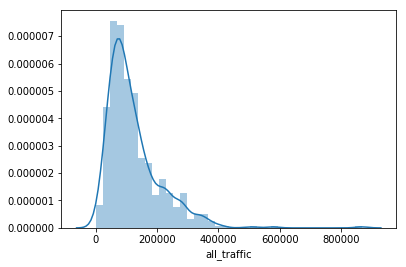

In [35]:
sns.distplot(weekly_avg, hist=True, kde=True);

Pickle the cleaned data to easily pick up again for exploration

In [38]:
clean_df.to_pickle('cleaned_turnstile_data2.pkl')